In [3]:
# Cell 0 — Bootstrap & Imports (stable)

import sys, subprocess, importlib

def ensure(mod_import_name, pip_name=None):
    try:
        importlib.import_module(mod_import_name)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", pip_name or mod_import_name])
    finally:
        globals()[mod_import_name] = importlib.import_module(mod_import_name)

# Ensure packages (import names on the left; pip names when different on the right)
ensure("numpy")
ensure("matplotlib")
ensure("tqdm")                       # module 'tqdm'
ensure("skimage", "scikit-image")    # module 'skimage'
ensure("cv2", "opencv-python")       # module 'cv2'
ensure("yaml", "pyyaml")             # optional

# Standard imports
import os, json, random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import tqdm                             # <-- module (not 'from tqdm import tqdm')
import skimage
from skimage.draw import polygon as sk_polygon
import cv2

# Jupyter niceties
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Repro-ish behavior
np.set_printoptions(precision=3, suppress=True)
random.seed(42); np.random.seed(42)

print("✅ Env ready:",
      f"numpy {np.__version__}, matplotlib {plt.matplotlib.__version__},",
      f"skimage {skimage.__version__}, tqdm {tqdm.__version__}, cv2 {cv2.__version__}")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
✅ Env ready: numpy 1.24.1, matplotlib 3.7.5, skimage 0.21.0, tqdm 4.67.1, cv2 4.12.0


In [4]:
# Cell 0a — Project Paths (with output root & versioned run dir)
from pathlib import Path
from datetime import datetime

def set_kitti_paths_and_outputs(abs_kitti_path: str, out_root: str = None, run_tag: str = None):
    """
    abs_kitti_path: absolute path to KITTI
                    (either .../kitti or .../kitti/training)
    out_root     : base folder for outputs (e.g., 'D:/bev_npu_outputs').
                   If None, defaults to project-root / 'outputs'
    run_tag      : optional name for this run (else timestamp)
    """
    p = Path(abs_kitti_path).resolve()
    if not p.exists():
        raise FileNotFoundError(f"KITTI path does not exist: {p}")

    # Normalize to training folder
    if p.name.lower() == "training":
        train_dir = p
    else:
        if (p / "training").exists():
            train_dir = p / "training"
        else:
            raise FileNotFoundError(f"No 'training' under {p}")

    # Notebook/project dirs
    NB_DIR = Path.cwd().resolve()
    PROJECT_DIR = NB_DIR.parent if NB_DIR.name.lower() == "notebooks" else NB_DIR

    # Dataset subfolders
    VELO   = train_dir / "velodyne"
    CALIB  = train_dir / "calib"
    LABELS = train_dir / "label_2"

    # Output root
    if out_root is None:
        OUT_ROOT = PROJECT_DIR / "outputs"
    else:
        OUT_ROOT = Path(out_root).resolve()

    # Versioned run dir
    if run_tag is None:
        run_tag = datetime.now().strftime("run_%Y-%m-%d_%H-%M-%S")
    OUT_DIR    = OUT_ROOT / run_tag
    OUT_BEV_U8 = OUT_DIR / "bev_u8"
    OUT_MASKS  = OUT_DIR / "masks"
    OUT_TILES  = OUT_DIR / "tiles"
    OUT_PLISTS = OUT_DIR / "playlists"
    for d in [OUT_DIR, OUT_BEV_U8, OUT_MASKS, OUT_TILES, OUT_PLISTS]:
        d.mkdir(parents=True, exist_ok=True)

    # Export globals for other cells
    g = globals()
    g["PROJECT_DIR"] = PROJECT_DIR
    g["KITTI_TRAIN_DIR"] = train_dir
    g["VELO"], g["CALIB"], g["LABELS"] = VELO, CALIB, LABELS
    g["OUT_ROOT"], g["OUT_DIR"] = OUT_ROOT, OUT_DIR
    g["OUT_BEV_U8"], g["OUT_MASKS"], g["OUT_TILES"], g["OUT_PLISTS"] = \
        OUT_BEV_U8, OUT_MASKS, OUT_TILES, OUT_PLISTS

    print("📁 PROJECT_DIR :", PROJECT_DIR)
    print("📦 KITTI_TRAIN :", KITTI_TRAIN_DIR)
    print("    VELO   :", VELO,   "| exists:", VELO.exists())
    print("    CALIB  :", CALIB,  "| exists:", CALIB.exists())
    print("    LABELS :", LABELS, "| exists:", LABELS.exists())
    print("🗂  OUT_ROOT  :", OUT_ROOT)
    print("🧪 OUT_DIR    :", OUT_DIR)

# >>> Set once per session:
set_kitti_paths_and_outputs(
    r"C:\Users\DELL\OpenPCDet\data\kitti\training",
    out_root=r"D:\Data\essentials\Thapar\MTech\Projects\Main proj\bev_npu_outputs"         # put outputs on D:
    # , run_tag="exp_kitti_pp_seg_oct03"   # (optional) custom name
)


📁 PROJECT_DIR : C:\Users\DELL\projects\bev_npu
📦 KITTI_TRAIN : C:\Users\DELL\OpenPCDet\data\kitti\training
    VELO   : C:\Users\DELL\OpenPCDet\data\kitti\training\velodyne | exists: True
    CALIB  : C:\Users\DELL\OpenPCDet\data\kitti\training\calib | exists: True
    LABELS : C:\Users\DELL\OpenPCDet\data\kitti\training\label_2 | exists: True
🗂  OUT_ROOT  : D:\Data\essentials\Thapar\MTech\Projects\Main proj\bev_npu_outputs
🧪 OUT_DIR    : D:\Data\essentials\Thapar\MTech\Projects\Main proj\bev_npu_outputs\run_2025-10-04_13-07-58


In [5]:
# Cell 0b — Specs (load/create)
import json

SPECS_DIR = PROJECT_DIR / "specs"; SPECS_DIR.mkdir(exist_ok=True)

bev_spec_path  = SPECS_DIR / "bev_spec.json"
tile_spec_path = SPECS_DIR / "tile_spec.json"

default_bev_spec = {
    "x_range": [0.0, 70.0],
    "y_range": [-40.0, 40.0],
    "z_range": [-3.0, 1.0],
    "H": 700, "W": 800,
    "channels": ["count","z_max","z_mean","i_mean","z_var"],
    "quant": {"count_cap": 12.0, "zvar_cap": 2.0}
}
default_tile_spec = {"T": 128, "overlap": 2, "order": "raster", "skip_empty_threshold": 4}

if not bev_spec_path.exists():
    bev_spec_path.write_text(json.dumps(default_bev_spec, indent=2))
if not tile_spec_path.exists():
    tile_spec_path.write_text(json.dumps(default_tile_spec, indent=2))

cfg   = json.loads(bev_spec_path.read_text())
tspec = json.loads(tile_spec_path.read_text())

print("BEV spec:", cfg)
print("Tile spec:", tspec)


BEV spec: {'x_range': [0.0, 70.0], 'y_range': [-40.0, 40.0], 'z_range': [-3.0, 1.0], 'H': 700, 'W': 800, 'channels': ['count', 'z_max', 'z_mean', 'i_mean', 'z_var'], 'quant': {'count_cap': 12.0, 'zvar_cap': 2.0}}
Tile spec: {'T': 128, 'overlap': 2, 'order': 'raster', 'skip_empty_threshold': 4}


In [6]:
# Cell 0c — Helpers
import numpy as np, random
from skimage.draw import polygon as sk_polygon

def load_points(bin_path: Path) -> np.ndarray:
    """KITTI velodyne .bin → [N,4] float32 (x,y,z,intensity)."""
    arr = np.fromfile(bin_path, dtype=np.float32)
    if arr.size % 4 != 0:
        raise ValueError(f"Bad BIN size: {bin_path}, floats={arr.size}")
    return arr.reshape(-1, 4)

def ensure_frame_id_list(limit=None):
    fids = sorted(p.stem for p in VELO.glob("*.bin"))
    if limit: fids = fids[:limit]
    if not fids:
        raise FileNotFoundError(f"No .bin files found under {VELO}")
    return fids

def colorize_mask(mask: np.ndarray, palette=None) -> np.ndarray:
    """mask [H,W]→RGB [H,W,3] for display. 0=bg,1=vehicle (extend later)."""
    if palette is None:
        palette = {0:(230,230,230), 1:(220,60,60)}  # RGB
    h,w = mask.shape
    img = np.zeros((h,w,3), dtype=np.uint8)
    for k, rgb in palette.items():
        img[mask==k] = rgb
    return img


In [43]:
# Cell A — Frame list & pick one
fids = ensure_frame_id_list()
print("Total frames:", len(fids), "Example:", fids[:5])
frame_id = fids[7]  # change this to try another frame
print("Using frame:", frame_id)


Total frames: 7481 Example: ['000000', '000001', '000002', '000003', '000004']
Using frame: 000007


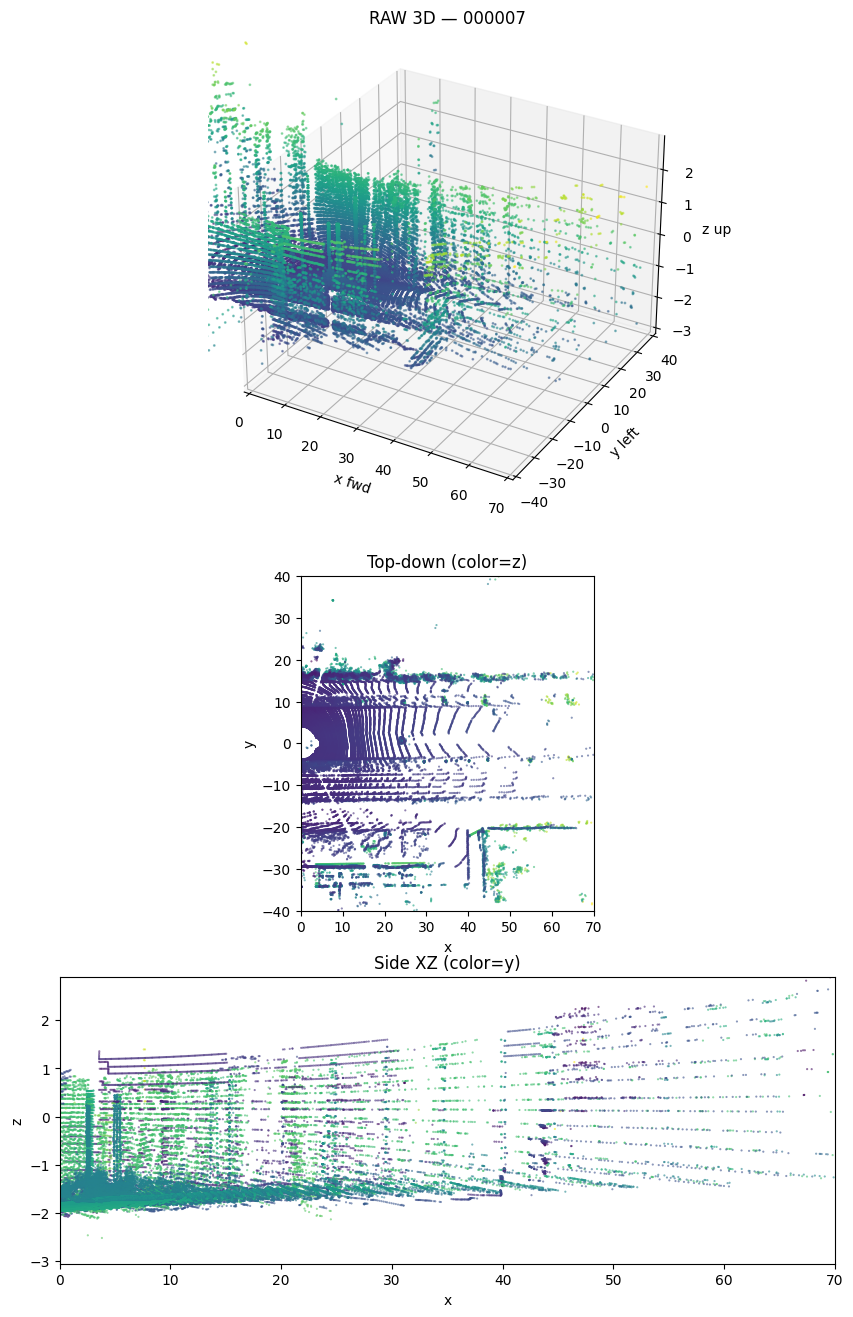

In [44]:
# Cell B — RAW visualize one frame (3D, top, side)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa

raw = load_points(VELO / f"{frame_id}.bin")
x,y,z,i = raw.T

xr, yr, zr = cfg["x_range"], cfg["y_range"], cfg["z_range"]

fig = plt.figure(figsize=(10, 16))
gs  = fig.add_gridspec(3,1, height_ratios=[2.0,1.4,1.2], hspace=0.18)

ax = fig.add_subplot(gs[0], projection='3d')
idx = np.random.choice(len(raw), size=min(len(raw), 80000), replace=False)
ax.scatter(x[idx], y[idx], z[idx], c=z[idx], s=1, alpha=0.5, cmap='viridis')
ax.set_title(f"RAW 3D — {frame_id}")
ax.set_xlabel("x fwd"); ax.set_ylabel("y left"); ax.set_zlabel("z up")
ax.set_xlim(xr); ax.set_ylim(yr); ax.set_zlim(z.min(), z.max())

m = (x>=xr[0])&(x<=xr[1])&(y>=yr[0])&(y<=yr[1])
ax2 = fig.add_subplot(gs[1])
ax2.scatter(x[m], y[m], c=z[m], s=0.3, alpha=0.6, cmap='viridis')
ax2.set_aspect('equal'); ax2.set_xlim(xr); ax2.set_ylim(yr)
ax2.set_title("Top-down (color=z)"); ax2.set_xlabel("x"); ax2.set_ylabel("y")

ax3 = fig.add_subplot(gs[2])
ax3.scatter(x[m], z[m], c=y[m], s=0.3, alpha=0.6, cmap='viridis')
ax3.set_xlim(xr); ax3.set_ylim(z.min(), z.max())
ax3.set_title("Side XZ (color=y)"); ax3.set_xlabel("x"); ax3.set_ylabel("z")

plt.show()


In [45]:
# Cell C — BEV build functions
def bev_from_points(points: np.ndarray, cfg: dict) -> np.ndarray:
    """[N,4]→[5,H,W] float: [count, z_max, z_mean, i_mean, z_var]."""
    x,y,z,i = points.T
    xr,yr,zr = cfg["x_range"], cfg["y_range"], cfg["z_range"]
    H,W = cfg["H"], cfg["W"]

    m = (x>=xr[0])&(x<=xr[1])&(y>=yr[0])&(y<=yr[1])&(z>=zr[0])&(z<=zr[1])
    x,y,z,i = x[m],y[m],z[m],i[m]

    row_scale = (H - 1) / (xr[1] - xr[0])
    col_scale = (W - 1) / (yr[1] - yr[0])
    iy = np.floor((x - xr[0]) * row_scale).astype(np.int32)
    ix = np.floor((y - yr[0]) * col_scale).astype(np.int32)
    lin = iy * W + ix

    count = np.bincount(lin, minlength=H*W).astype(np.float32).reshape(H, W)
    sum_z  = np.bincount(lin, weights=z,   minlength=H*W).reshape(H, W)
    sum_z2 = np.bincount(lin, weights=z*z, minlength=H*W).reshape(H, W)
    sum_i  = np.bincount(lin, weights=i,   minlength=H*W).reshape(H, W)

    zmax = np.full(H*W, -1e9, dtype=np.float32)
    np.maximum.at(zmax, lin, z)
    zmax = zmax.reshape(H, W)

    eps   = 1e-6
    zmean = sum_z / np.maximum(count, eps)
    imean = sum_i / np.maximum(count, eps)
    zvar  = (sum_z2 / np.maximum(count, eps)) - zmean**2
    zvar  = np.clip(zvar, 0.0, None)

    return np.stack([count, zmax, zmean, imean, zvar], axis=0)

def quantize_bev_u8(bev: np.ndarray, cfg: dict) -> np.ndarray:
    """[5,H,W] float → uint8 with fixed caps."""
    zr = cfg["z_range"]; q = cfg["quant"]
    q0 = np.clip((bev[0] / q["count_cap"]) * 255.0, 0, 255).astype(np.uint8)
    z_to_u8 = lambda a: np.clip(((a - zr[0])/(zr[1]-zr[0]))*255.0, 0, 255).astype(np.uint8)
    q1 = z_to_u8(bev[1]); q2 = z_to_u8(bev[2])
    q3 = np.clip(bev[3] * 255.0, 0, 255).astype(np.uint8)
    q4 = np.clip((bev[4] / q["zvar_cap"]) * 255.0, 0, 255).astype(np.uint8)
    return np.stack([q0,q1,q2,q3,q4], axis=0)


In [46]:
# Cell D — Save BEV (u8) for N frames
from tqdm import tqdm

some_fids = fids[:50]  # adjust (e.g., 200) when you’re ready

for fid in tqdm(some_fids, desc="BEV u8"):
    bev_path = OUT_BEV_U8 / f"{fid}.npy"
    if bev_path.exists(): 
        continue
    raw = load_points(VELO / f"{fid}.bin")
    bev_f = bev_from_points(raw, cfg)
    bev_u = quantize_bev_u8(bev_f, cfg)
    np.save(bev_path, bev_u)

print("Saved BEVs at:", OUT_BEV_U8)


BEV u8: 100%|███████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 12501.65it/s]

Saved BEVs at: D:\Data\essentials\Thapar\MTech\Projects\Main proj\bev_npu_outputs\run_2025-10-04_13-07-58\bev_u8


In [47]:
# Cell E — Label → BEV mask (0=bg, 1=vehicle)
import numpy as np

def read_calib(calib_file: Path):
    """Parse KITTI calib to dict of matrices."""
    lines = calib_file.read_text().strip().splitlines()
    data = {}
    for ln in lines:
        k, val = ln.split(":", 1)
        arr = np.fromstring(val, sep=' ')
        if k.startswith("R0_rect"):
            data["R0_rect"] = arr.reshape(3,3)
        elif k.startswith("Tr_velo_to_cam"):
            data["Tr_velo_to_cam"] = arr.reshape(3,4)
    # Homogenize
    R0 = np.eye(4); R0[:3,:3] = data["R0_rect"]
    T  = np.eye(4); T[:3,:4]  = data["Tr_velo_to_cam"]
    data["T_cam_to_velo"] = np.linalg.inv(R0 @ T)  # 4x4
    return data

def read_labels(label_file: Path):
    """Return list of vehicle 3D boxes from KITTI label_2."""
    boxes = []
    for ln in label_file.read_text().strip().splitlines():
        parts = ln.split()
        cls = parts[0]
        if cls not in ("Car","Van","Truck"):  # keep it simple for now
            continue
        # fields per KITTI: truncated, occluded, alpha, bbox(4), dims(h,w,l), loc(x,y,z), ry
        h,w,l = map(float, parts[8:11])
        x,y,z = map(float, parts[11:14])  # camera coords
        ry    = float(parts[14])
        boxes.append({"h":h,"w":w,"l":l,"x":x,"y":y,"z":z,"ry":ry})
    return boxes

def corners_3d_cam(box):
    """8 corners (3x8) in CAM coords."""
    h,w,l = box["h"], box["w"], box["l"]
    # in object coords (origin at box center bottom)
    x_c = np.array([ l/2,  l/2, -l/2, -l/2,  l/2,  l/2, -l/2, -l/2 ])
    y_c = np.array([   0,    0,    0,    0,  -h,  -h,   -h,   -h ])
    z_c = np.array([ w/2, -w/2, -w/2, w/2, w/2, -w/2, -w/2,  w/2 ])

    ry = box["ry"]; c,s = np.cos(ry), np.sin(ry)
    R = np.array([[ c, 0,  s],
                  [ 0, 1,  0],
                  [-s, 0,  c]])
    corners = R @ np.vstack((x_c, y_c, z_c))
    corners[0,:] += box["x"]
    corners[1,:] += box["y"]
    corners[2,:] += box["z"]
    return corners  # 3x8

def cam_to_velo(X_cam: np.ndarray, T_cam_to_velo: np.ndarray):
    """(3xN) → (3xN) using 4x4 T."""
    N = X_cam.shape[1]
    Xc = np.vstack((X_cam, np.ones((1,N))))
    Xv = T_cam_to_velo @ Xc
    return Xv[:3,:]

def poly_to_pixels(xv, yv, cfg):
    """map metric (x fwd, y left) → pixel rows/cols."""
    H,W = cfg["H"], cfg["W"]
    xr,yr = cfg["x_range"], cfg["y_range"]
    row_scale = (H - 1) / (xr[1]-xr[0])
    col_scale = (W - 1) / (yr[1]-yr[0])
    rows = np.floor((xv - xr[0]) * row_scale).astype(np.int32)
    cols = np.floor((yv - yr[0]) * col_scale).astype(np.int32)
    return rows, cols

def rasterize_mask_for_frame(fid: str, cfg: dict, OUT_MASKS: Path):
    calib = read_calib(CALIB / f"{fid}.txt")
    boxes = read_labels(LABELS / f"{fid}.txt")
    H,W   = cfg["H"], cfg["W"]
    mask  = np.zeros((H,W), dtype=np.uint8)

    for b in boxes:
        # 3D corners in camera
        C_cam = corners_3d_cam(b)           # 3x8
        # to Velodyne coords
        C_vel = cam_to_velo(C_cam, calib["T_cam_to_velo"])  # 3x8
        # bottom face corners indices [0,1,2,3] in our construction
        bottom = C_vel[:, [0,1,2,3]]
        xv, yv = bottom[0,:], bottom[1,:]

        # clip to ROI (simple check: if completely outside, skip)
        xr,yr = cfg["x_range"], cfg["y_range"]
        if (xv.max() < xr[0]) or (xv.min() > xr[1]) or (yv.max() < yr[0]) or (yv.min() > yr[1]):
            continue

        rr, cc = poly_to_pixels(xv, yv, cfg)
        # keep only points inside canvas
        m = (rr>=0)&(rr< H)&(cc>=0)&(cc< W)
        if m.sum() < 3:  # degenerate
            continue
        r = rr[m]; c = cc[m]
        pr, pc = sk_polygon(r, c, shape=(H,W))
        mask[pr, pc] = 1  # vehicle

    np.save(OUT_MASKS / f"{fid}.npy", mask)
    return mask

# Run for one frame + preview overlay
mask = rasterize_mask_for_frame(frame_id, cfg, OUT_MASKS)
import matplotlib.pyplot as plt
bev_u = np.load(OUT_BEV_U8 / f"{frame_id}.npy") if (OUT_BEV_U8 / f"{frame_id}.npy").exists() else quantize_bev_u8(bev_from_points(load_points(VELO / f"{frame_id}.bin"), cfg), cfg)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(bev_u[0], cmap='gray', origin='lower'); plt.title("BEV occupancy"); plt.axis('off')
overlay = (0.6*colorize_mask(mask) + 0.4*np.stack([bev_u[0]]*3, axis=-1)).astype(np.uint8)
plt.subplot(1,2,2); plt.imshow(overlay, origin='lower'); plt.title("Mask overlay"); plt.axis('off')
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\DELL\\OpenPCDet\\data\\kitti\\training\\training\\calib\\000007.txt'

In [ ]:
# Cell F — Tiling BEV & Mask into paired tiles
import csv

T         = tspec["T"]
overlap   = tspec["overlap"]
skip_thr  = tspec["skip_empty_threshold"]  # min nonzero pixels to keep

def tile_indices(H, W, T, overlap):
    step = T - overlap
    rows = list(range(0, H - T + 1, step))
    cols = list(range(0, W - T + 1, step))
    return rows, cols

def export_tiles_for_frame(fid: str):
    bev = np.load(OUT_BEV_U8 / f"{fid}.npy")      # [5,H,W] u8
    msk = np.load(OUT_MASKS / f"{fid}.npy")       # [H,W] u8
    H,W = bev.shape[1], bev.shape[2]

    rlist, clist = tile_indices(H, W, T, overlap)
    kept = 0
    plist_rows = []
    for ri, r0 in enumerate(rlist):
        for ci, c0 in enumerate(clist):
            bev_tile = bev[:, r0:r0+T, c0:c0+T]
            msk_tile = msk[   r0:r0+T, c0:c0+T]
            nonzero  = int((bev_tile[0] > 0).sum())
            if nonzero < skip_thr:
                continue
            tile_id = f"{fid}_r{r0:04d}_c{c0:04d}"
            np.save(OUT_TILES / f"{tile_id}_bev.npy",  bev_tile)
            np.save(OUT_TILES / f"{tile_id}_mask.npy", msk_tile)
            plist_rows.append([fid, tile_id, r0, c0, T, T, nonzero])
            kept += 1
    # append playlist CSV
    pl = OUT_PLISTS / f"{fid}_tiles.csv"
    with pl.open("w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["frame_id","tile_id","row0","col0","H","W","nonzero"])
        w.writerows(plist_rows)
    return kept

# Run on your 'some_fids'
kept_total = 0
for fid in tqdm(some_fids, desc="Tiling"):
    # ensure mask exists
    if not (OUT_MASKS / f"{fid}.npy").exists():
        rasterize_mask_for_frame(fid, cfg, OUT_MASKS)
    kept_total += export_tiles_for_frame(fid)

print("Tiles exported (kept):", kept_total, " →", OUT_TILES)


Train tiles: 800 | Val tiles: 201


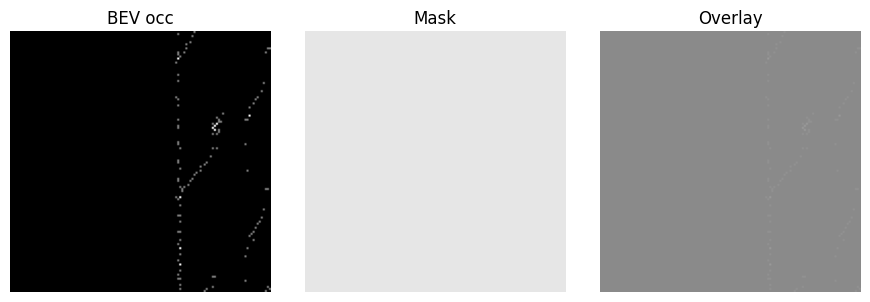

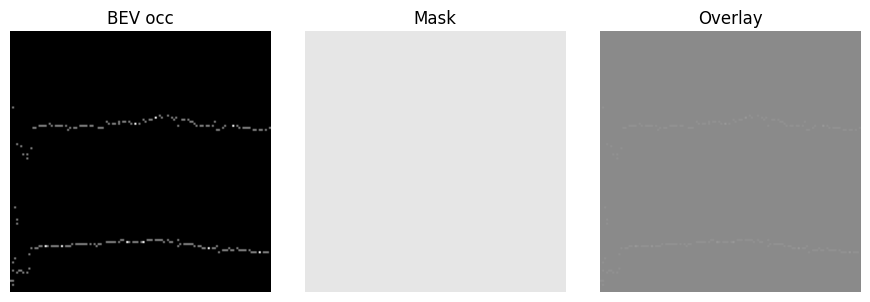

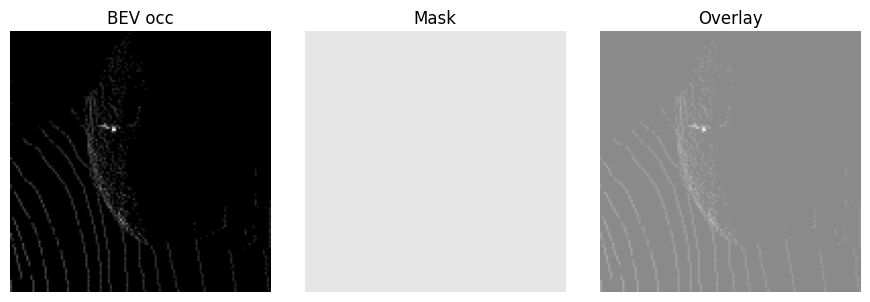

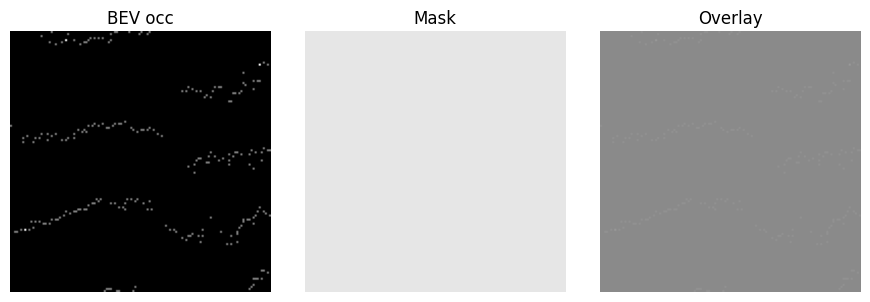

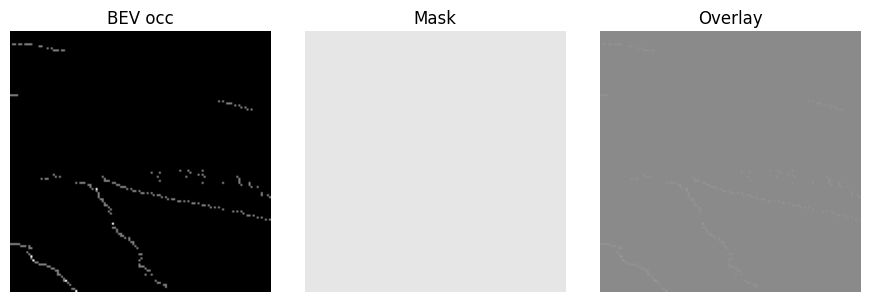

In [48]:
# Cell G — Splits + Preview
import random, glob, matplotlib.pyplot as plt

all_bev_tiles = sorted(glob.glob(str(OUT_TILES / "*_bev.npy")))
random.shuffle(all_bev_tiles)

# simple 80/20
n = len(all_bev_tiles)
train_files = all_bev_tiles[: int(0.8*n)]
val_files   = all_bev_tiles[int(0.8*n):]

(SPECS_DIR / "splits").mkdir(exist_ok=True)
(Path(SPECS_DIR) / "splits" / "train.txt").write_text("\n".join(train_files))
(Path(SPECS_DIR) / "splits" / "val.txt").write_text("\n".join(val_files))

print(f"Train tiles: {len(train_files)} | Val tiles: {len(val_files)}")

# Preview a few random tiles
def show_pair(bev_path):
    bev = np.load(bev_path)              # [5,T,T] u8
    msk = np.load(bev_path.replace("_bev.npy","_mask.npy"))
    fig,axs=plt.subplots(1,3, figsize=(9,3))
    axs[0].imshow(bev[0], origin='lower', cmap='gray'); axs[0].set_title("BEV occ"); axs[0].axis('off')
    axs[1].imshow(colorize_mask(msk), origin='lower');  axs[1].set_title("Mask"); axs[1].axis('off')
    overlay = (0.6*colorize_mask(msk) + 0.4*np.stack([bev[0]]*3, axis=-1)).astype(np.uint8)
    axs[2].imshow(overlay, origin='lower'); axs[2].set_title("Overlay"); axs[2].axis('off')
    plt.tight_layout(); plt.show()

for bevp in random.sample(train_files, k=min(5, len(train_files))):
    show_pair(bevp)


In [49]:
# Cell H1 — Audit: BEV/mask/tile counts & positives
import glob, numpy as np, os
from pathlib import Path

def audit_counts():
    bev_files  = sorted(glob.glob(str(OUT_BEV_U8/"*.npy")))
    mask_files = sorted(glob.glob(str(OUT_MASKS/"*.npy")))
    tile_bevs  = sorted(glob.glob(str(OUT_TILES/"*_bev.npy")))
    tile_msks  = [p.replace("_bev.npy","_mask.npy") for p in tile_bevs]

    # quick stats on tiles
    pos_tiles = 0
    total_px  = 0
    pos_px    = 0
    sample_k  = min(2000, len(tile_msks))
    idxs = np.linspace(0, len(tile_msks)-1, num=sample_k, dtype=int) if len(tile_msks)>0 else []
    for i in idxs:
        m = np.load(tile_msks[i])
        total_px += m.size
        pos_px   += (m>0).sum()
        pos_tiles += int((m>0).any())

    print("Frames:  BEV:", len(bev_files), "| MASK:", len(mask_files))
    print("Tiles:   BEV:", len(tile_bevs),  "| POS (sampled):", pos_tiles, f"/ {sample_k}")
    if total_px>0:
        print("Mask pixel rate (sampled):", f"{100.0*pos_px/total_px:.3f}%")

audit_counts()


Frames:  BEV: 50 | MASK: 50
Tiles:   BEV: 1001 | POS (sampled): 164 / 1001
Mask pixel rate (sampled): 0.731%


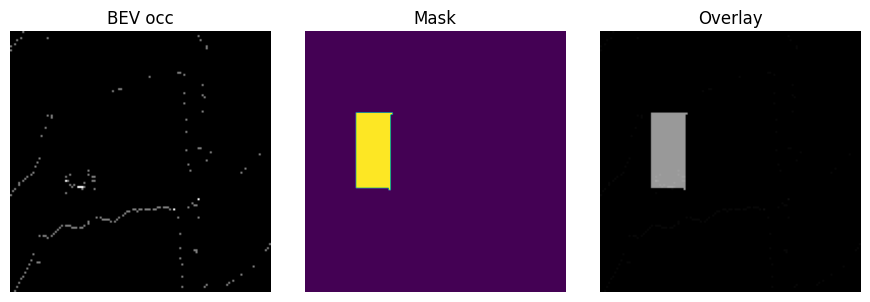

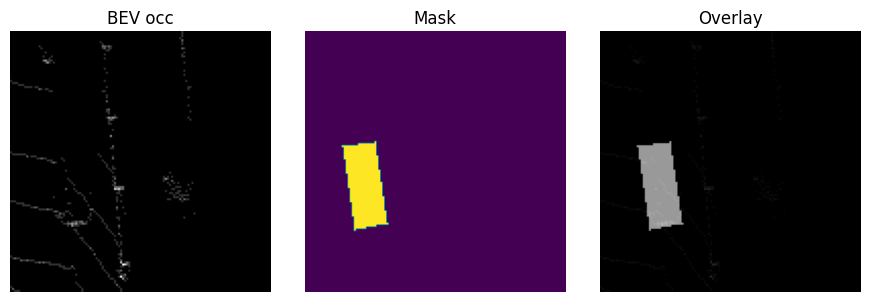

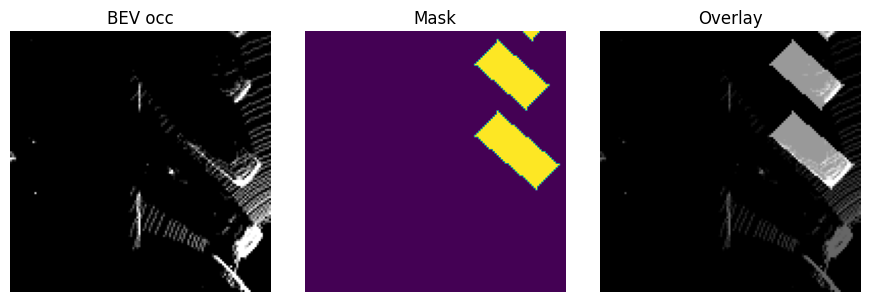

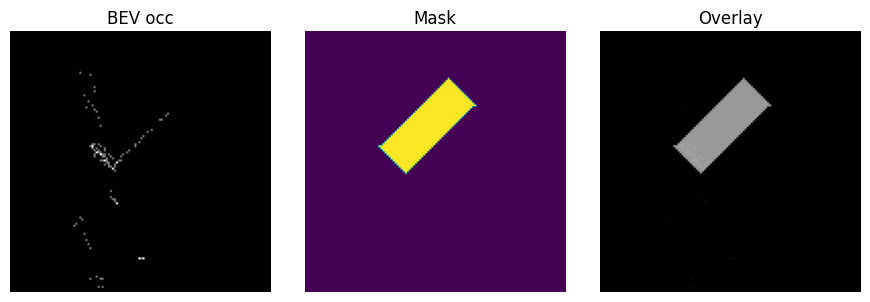

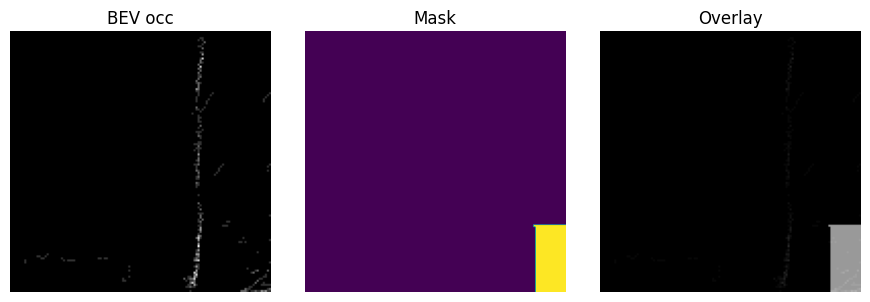

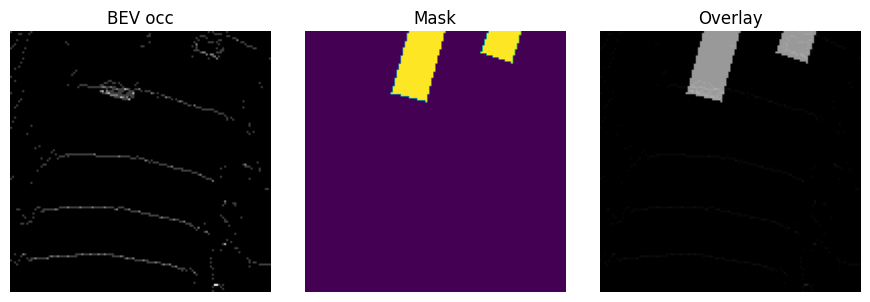

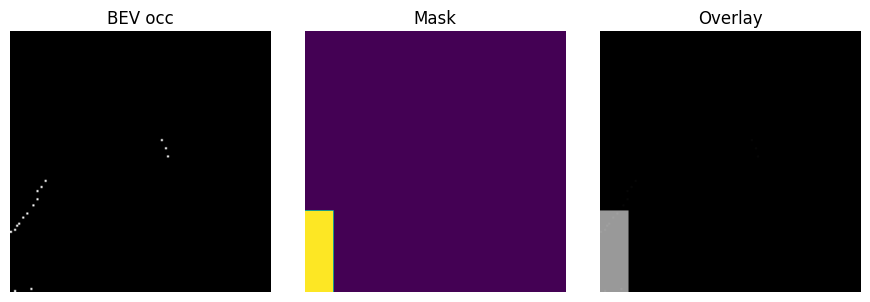

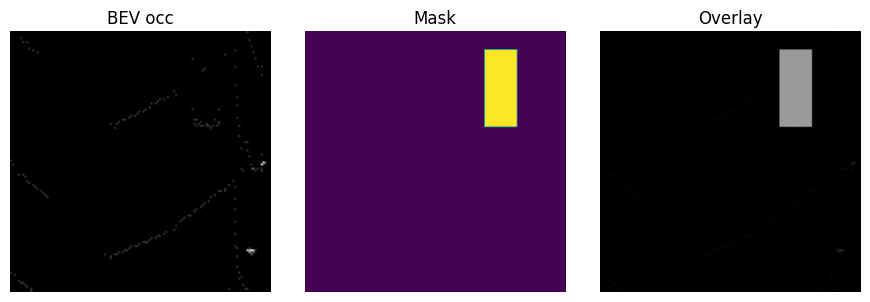

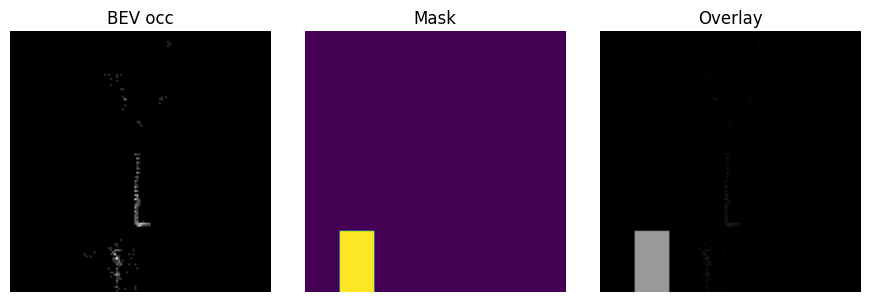

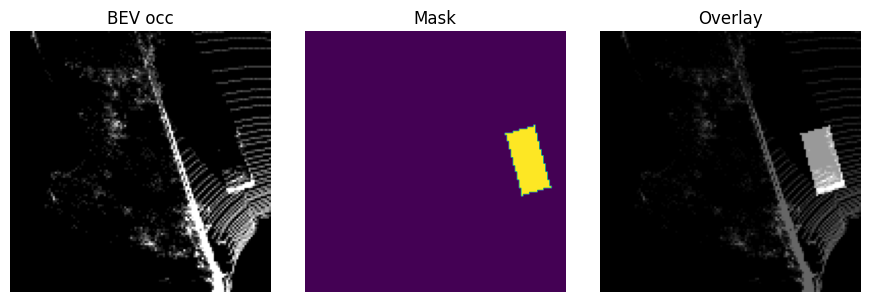

Shown positive tiles: 10


In [50]:
# Cell H2 — Visualize positive tiles only
import random, glob, numpy as np, matplotlib.pyplot as plt

all_bev_tiles = sorted(glob.glob(str(OUT_TILES/"*_bev.npy")))
random.shuffle(all_bev_tiles)

shown = 0
for bevp in all_bev_tiles:
    mskp = bevp.replace("_bev.npy","_mask.npy")
    m = np.load(mskp)
    if (m>0).sum() == 0:
        continue
    b = np.load(bevp)
    fig,axs=plt.subplots(1,3, figsize=(9,3))
    axs[0].imshow(b[0], origin='lower', cmap='gray'); axs[0].set_title("BEV occ"); axs[0].axis('off')
    axs[1].imshow(m, origin='lower'); axs[1].set_title("Mask"); axs[1].axis('off')
    overlay = (0.6*np.stack([m*255]*3,axis=-1) + 0.4*np.stack([b[0]]*3,axis=-1)).astype(np.uint8)
    axs[2].imshow(overlay, origin='lower'); axs[2].set_title("Overlay"); axs[2].axis('off')
    plt.tight_layout(); plt.show()
    shown += 1
    if shown >= 10:
        break

print("Shown positive tiles:", shown)


In [51]:
# Cell H2g_setup — parse label_2 & calib, camera→LiDAR helpers

from pathlib import Path
import numpy as np
import re

KITTI_ROOT = Path(DATA_ROOT)
LAB2 = KITTI_ROOT / "training" / "label_2"
CALIB = KITTI_ROOT / "training" / "calib"

# --- parse a label_2 line into a dict ---
def parse_label_line(line: str):
    # KITTI format: type, trunc, occ, alpha, bbox4, dims3(h,w,l), loc3(x,y,z), ry
    f = line.strip().split()
    obj = {
        "type": f[0],
        "h": float(f[8]), "w": float(f[9]), "l": float(f[10]),           # dims in cam coords
        "x": float(f[11]), "y": float(f[12]), "z": float(f[13]),         # location in cam coords
        "ry": float(f[14]),                                              # yaw around cam-Y
    }
    return obj

def load_label2(fid: str):
    p = LAB2 / f"{fid}.txt"
    if not p.exists(): return []
    return [parse_label_line(l) for l in p.read_text().splitlines() if l.strip()]

# --- parse calib file: we need Tr_velo_to_cam (3x4) ---
def load_calib(fid: str):
    p = CALIB / f"{fid}.txt"
    if not p.exists():
        raise FileNotFoundError(f"calib not found: {p}")
    M = {}
    for line in p.read_text().splitlines():
        if ":" not in line: continue
        k, v = line.split(":", 1)
        vals = np.fromstring(v, sep=' ')
        if k.strip() == "Tr_velo_to_cam":
            M["T_v2c"] = vals.reshape(3,4)
        elif k.strip().startswith("R0_rect"):
            M["R0"] = vals.reshape(3,3)
        # P2 etc not strictly needed for our BEV mask
    if "T_v2c" not in M:
        raise ValueError("Tr_velo_to_cam missing in calib")
    # promote to 4x4
    T = np.eye(4); T[:3,:4] = M["T_v2c"]
    M["T_v2c_4x4"] = T
    # Precompute inverse (cam→velo)
    M["T_c2v_4x4"] = np.linalg.inv(T)
    return M

# --- transform points cam→velo (homogeneous) ---
def cam_to_velo(xyz_cam: np.ndarray, calib):
    assert xyz_cam.shape[-1] == 3
    N = xyz_cam.shape[0]
    homo = np.concatenate([xyz_cam, np.ones((N,1))], axis=1)
    out = (calib["T_c2v_4x4"] @ homo.T).T[:, :3]
    return out

# --- map meters→bev pixel indices (same mapping as your BEV code) ---
def meters_to_bev_xy(x_m, y_m, cfg):
    xr, yr = cfg["x_range"], cfg["y_range"]
    H, W   = cfg["H"], cfg["W"]
    row_scale = (H - 1) / (xr[1] - xr[0])   # rows per meter (x forward)
    col_scale = (W - 1) / (yr[1] - yr[0])   # cols  per meter (y left)
    iy = np.floor((x_m - xr[0]) * row_scale).astype(np.int32)  # 0..H-1
    ix = np.floor((y_m - yr[0]) * col_scale).astype(np.int32)  # 0..W-1
    return iy, ix


In [52]:
# Cell H2g_pathsfix — point to the *actual* folders and sanity-check

from pathlib import Path

# 1) Point DATA_ROOT to the *training* folder you showed:
DATA_ROOT = Path(r"C:\Users\DELL\OpenPCDet\data\kitti\training")

# 2) Point OUT_ROOT to where you want NEW outputs to go (D: to save space)
OUT_ROOT = Path(r"D:\bev_npu_outputs"); OUT_ROOT.mkdir(parents=True, exist_ok=True)

# 3) Define subfolders correctly (no extra 'training'!)
VELO_DIR  = DATA_ROOT / "velodyne"
LAB2_DIR  = DATA_ROOT / "label_2"
CALIB_DIR = DATA_ROOT / "calib"
BEV_DIR   = OUT_ROOT  / "bev_u8"; BEV_DIR.mkdir(exist_ok=True)

print("Exists?")
print("  VELO_DIR ", VELO_DIR,  "->", VELO_DIR.exists())
print("  LAB2_DIR ", LAB2_DIR,  "->", LAB2_DIR.exists())
print("  CALIB_DIR", CALIB_DIR, "->", CALIB_DIR.exists())
print("  BEV_DIR  ", BEV_DIR,   "->", BEV_DIR.exists())

# Count files
n_velo  = len(list(VELO_DIR.glob("*.bin")))
n_lab2  = len(list(LAB2_DIR.glob("*.txt")))
n_calib = len(list(CALIB_DIR.glob("*.txt")))
n_bev   = len(list(BEV_DIR.glob("*.npy")))
print(f"Files: velodyne={n_velo}  label_2={n_lab2}  calib={n_calib}  bev_u8_npy={n_bev}")

# Build ID intersection (only using DATA_ROOT; BEV will be added after we generate it)
ids_velo  = {p.stem for p in VELO_DIR.glob('*.bin')}
ids_lab2  = {p.stem for p in LAB2_DIR.glob('*.txt')}
ids_calib = {p.stem for p in CALIB_DIR.glob('*.txt')}
ID_ALL    = sorted(ids_velo & ids_lab2 & ids_calib)
print("Intersect of raw/labels/calib:", len(ID_ALL))
if len(ID_ALL)==0:
    print("⚠️ If this is 0, something’s still off in DATA_ROOT.")


Exists?
  VELO_DIR  C:\Users\DELL\OpenPCDet\data\kitti\training\velodyne -> True
  LAB2_DIR  C:\Users\DELL\OpenPCDet\data\kitti\training\label_2 -> True
  CALIB_DIR C:\Users\DELL\OpenPCDet\data\kitti\training\calib -> True
  BEV_DIR   D:\bev_npu_outputs\bev_u8 -> True
Files: velodyne=7481  label_2=7481  calib=7481  bev_u8_npy=100
Intersect of raw/labels/calib: 7481


In [53]:
# Cell H2g_makebev_quick — generate a small set of BEV npys under OUT_ROOT/bev_u8

import numpy as np
from tqdm import tqdm

def load_points_kitti_bin(path):
    # KITTI velodyne: float32 [x,y,z,intensity]
    return np.fromfile(path, dtype=np.float32).reshape(-1,4)

to_make = ID_ALL[:100]   # just 100 frames to start; increase later
made = 0
for fid in tqdm(to_make, desc="bev_gen"):
    in_p  = VELO_DIR / f"{fid}.bin"
    out_p = BEV_DIR  / f"{fid}.npy"
    if out_p.exists(): 
        continue
    pts = load_points_kitti_bin(in_p)
    bev_f = bev_from_points(pts, cfg)         # from your earlier cell
    bev_u = quantize_bev_u8(bev_f, cfg)       # from your earlier cell
    np.save(out_p, bev_u)
    made += 1

print("Generated BEV npys:", made, "→", BEV_DIR)


bev_gen: 100%|████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 11112.51it/s]

Generated BEV npys: 0 → D:\bev_npu_outputs\bev_u8


In [54]:
# Cell H2g_ids — discover IDs present in BEV + label_2 + calib

ids_bev   = {p.stem for p in (OUT_ROOT / "bev_u8").glob("*.npy")}
ids_lab2  = {p.stem for p in LAB2_DIR.glob("*.txt")}
ids_calib = {p.stem for p in CALIB_DIR.glob("*.txt")}

BEV_IDS = sorted(ids_bev & ids_lab2 & ids_calib)
print(f"Found: bev={len(ids_bev)}  label_2={len(ids_lab2)}  calib={len(ids_calib)}  -> intersect={len(BEV_IDS)}")

if not BEV_IDS:
    print("⚠️ If intersect=0, generate BEVs first with H2g_makebev_quick, or check paths.")


Found: bev=100  label_2=7481  calib=7481  -> intersect=100


In [55]:
#Cell H2g_keep
KEEP = {"Car","Van","Truck"}   # start with vehicles
# KEEP = {"Car","Van","Truck","Cyclist","Pedestrian"}  # add later if you want


In [56]:
#Cell H2g_calib

def load_calib(fid: str):
    p = CALIB_DIR / f"{fid}.txt"
    txt = p.read_text().splitlines()
    R0, T_v2c = None, None
    for line in txt:
        if line.startswith("R0_rect:"):
            vals = np.fromstring(line.split(":",1)[1], sep=' ')
            R0 = vals.reshape(3,3)
        elif line.startswith("Tr_velo_to_cam:"):
            vals = np.fromstring(line.split(":",1)[1], sep=' ')
            T_v2c = vals.reshape(3,4)

    if R0 is None or T_v2c is None:
        raise ValueError("Missing R0_rect or Tr_velo_to_cam in calib file")

    # Lift to 4x4
    R4 = np.eye(4); R4[:3,:3] = R0
    T4 = np.eye(4); T4[:3,:4] = T_v2c

    # cam_rect = R0 * Tr * velo   =>   velo = (R0*Tr)^(-1) * cam_rect
    A = R4 @ T4
    A_inv = np.linalg.inv(A)
    return {"A_camrect_from_velo": A, "A_velo_from_camrect": A_inv}

def cam_to_velo(xyz_cam_rect: np.ndarray, calib):
    N = xyz_cam_rect.shape[0]
    homo = np.concatenate([xyz_cam_rect, np.ones((N,1))], axis=1)  # (N,4)
    out = (calib["A_velo_from_camrect"] @ homo.T).T[:, :3]
    return out


In [57]:
#Cell H2g_labels
def load_label2(fid: str):
    """
    Returns a list of dicts with:
      type, h,w,l, x_cam,y_cam,z_cam, ry  (KITTI rectified-camera coords)
    """
    recs = []
    for line in (LAB2_DIR / f"{fid}.txt").read_text().splitlines():
        if not line.strip(): continue
        parts = line.split()
        typ = parts[0]
        if typ == "DontCare": 
            continue
        # KITTI: h,w,l, then location x,y,z (in cam), then ry
        h, w, l = map(float, parts[8:11])
        x, y, z = map(float, parts[11:14])
        ry      = float(parts[14])
        recs.append({"type": typ, "h":h, "w":w, "l":l, "x":x, "y":y, "z":z, "ry":ry})
    return recs


In [58]:
#Cell H2g_rectmask

from skimage.draw import polygon

def boxes3d_to_bev_mask(fid: str, cfg, keep=KEEP):
    """
    Build a binary BEV mask (H,W) with 1s where vehicle footprints lie.
    Uses oriented rectangles from 3D boxes.
    """
    H, W     = cfg["H"], cfg["W"]
    xr, yr   = cfg["x_range"], cfg["y_range"]  # meters
    labs     = load_label2(fid)
    calib    = load_calib(fid)
    mask     = np.zeros((H,W), dtype=np.uint8)

    # metric -> grid scale
    row_scale = (H - 1) / (xr[1] - xr[0])   # rows per meter (forward)
    col_scale = (W - 1) / (yr[1] - yr[0])   # cols  per meter (left)

    for o in labs:
        if o["type"] not in keep: 
            continue

        # center in camera rect coords → LiDAR (velo) coords
        c_cam = np.array([[o["x"], o["y"], o["z"]]], dtype=np.float32)
        c_velo = cam_to_velo(c_cam, calib)[0]   # [x_fwd, y_left, z_up] in meters

        # heading: take camera forward unit [0,0,1], rotate by ry around cam Y:
        d_cam = np.array([[np.sin(o["ry"]), 0.0, np.cos(o["ry"])]], dtype=np.float32)
        # move a small step along heading (e.g. 1 m) to get a second point, then transform:
        p2_cam = c_cam + d_cam
        p2_velo = cam_to_velo(p2_cam, calib)[0]
        heading = p2_velo[:2] - c_velo[:2]             # in LiDAR XY plane
        yaw = np.arctan2(heading[1], heading[0])       # angle in BEV plane

        # Footprint rectangle (length along heading, width across)
        L, Wcar = o["l"], o["w"]
        dx = (L/2.0) * np.cos(yaw);  dy = (L/2.0) * np.sin(yaw)
        wx = (Wcar/2.0) * -np.sin(yaw); wy = (Wcar/2.0) *  np.cos(yaw)

        # 4 corners in meters (x,y)
        cx, cy = c_velo[0], c_velo[1]
        corners = np.array([
            [cx + dx + wx, cy + dy + wy],
            [cx + dx - wx, cy + dy - wy],
            [cx - dx - wx, cy - dy - wy],
            [cx - dx + wx, cy - dy + wy],
        ], dtype=np.float32)

        # clip/discard if outside ROI
        if (corners[:,0].max() < xr[0]) or (corners[:,0].min() > xr[1]) or \
           (corners[:,1].max() < yr[0]) or (corners[:,1].min() > yr[1]):
            continue

        # meters → grid (row = x, col = y)
        rows = ( (corners[:,0] - xr[0]) * row_scale ).clip(0, H-1)
        cols = ( (corners[:,1] - yr[0]) * col_scale ).clip(0, W-1)

        rr, cc = polygon(rows, cols, (H,W))
        mask[rr, cc] = 1

    return mask


Objects: ['Car', 'Car', 'Car', 'Cyclist']
KEEP count: 3


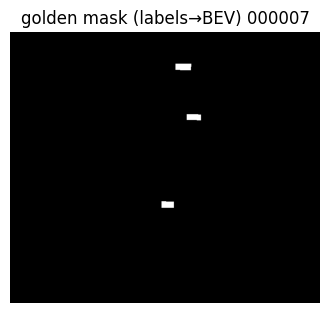

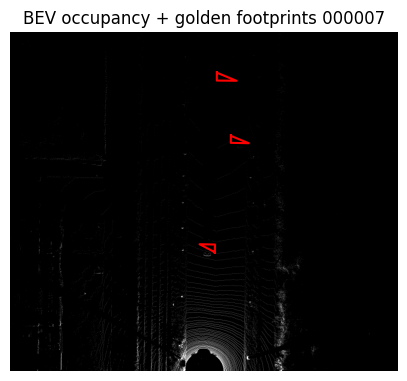

In [59]:
#Cell H2g_dgb_00007
# Make sure you actually have a BEV for 0007 (or generate it quickly)
fid = "000007"

# Show labels in KEEP
labs = load_label2(fid)
print("Objects:", [o["type"] for o in labs])
print("KEEP count:", sum(o["type"] in KEEP for o in labs))

# Build mask from labels (golden)
g = boxes3d_to_bev_mask(fid, cfg, KEEP)
plt.figure(figsize=(4,4)); plt.imshow(g, origin='lower', cmap='gray')
plt.title(f"golden mask (labels→BEV) {fid}"); plt.axis('off'); plt.show()

# If you saved a BEV raster earlier, overlay corners to visually confirm
bev_path = OUT_ROOT / "bev_u8" / f"{fid}.npy"
if bev_path.exists():
    bev = np.load(bev_path)  # [5,H,W] uint8
    plt.figure(figsize=(5,5)); plt.imshow(bev[0], origin='lower', cmap='gray'); plt.axis('off')
    plt.title(f"BEV occupancy + golden footprints {fid}")

    # draw rectangles as outlines (recompute corners)
    H, W     = cfg["H"], cfg["W"]
    xr, yr   = cfg["x_range"], cfg["y_range"]
    row_scale = (H - 1) / (xr[1] - xr[0])
    col_scale = (W - 1) / (yr[1] - yr[0])
    import matplotlib.patches as patches

    calib = load_calib(fid)
    for o in labs:
        if o["type"] not in KEEP: continue

        c_cam = np.array([[o["x"], o["y"], o["z"]]], dtype=np.float32)
        c_velo = cam_to_velo(c_cam, calib)[0]
        d_cam = np.array([[np.sin(o["ry"]), 0.0, np.cos(o["ry"])]], dtype=np.float32)
        p2_velo = cam_to_velo(c_cam + d_cam, calib)[0]
        yaw = np.arctan2(p2_velo[1]-c_velo[1], p2_velo[0]-c_velo[0])

        L, Wcar = o["l"], o["w"]
        dx = (L/2.0) * np.cos(yaw);  dy = (L/2.0) * np.sin(yaw)
        wx = (Wcar/2.0) * -np.sin(yaw); wy = (Wcar/2.0) *  np.cos(yaw)
        corners = np.array([
            [c_velo[0] + dx + wx, c_velo[1] + dy + wy],
            [c_velo[0] + dx - wx, c_velo[1] + dy - wy],
            [c_velo[0] - dx - wx, c_velo[1] - dy - wy],
            [c_velo[0] - dx + wx, c_velo[1] + dy + wy],
        ], dtype=np.float32)

        rows = ((corners[:,0] - xr[0]) * row_scale)
        cols = ((corners[:,1] - yr[0]) * col_scale)
        plt.plot(cols[[0,1,2,3,0]], rows[[0,1,2,3,0]], '-', lw=1.5, color='red')

    plt.show()
else:
    print("No BEV raster saved for", fid, "— generate with your earlier BEV export cells.")


In [60]:
#Cell H2h_eval
from tqdm import tqdm

def golden_mask_for_frame(fid, cfg, keep=KEEP):
    return boxes3d_to_bev_mask(fid, cfg, keep)

def load_mask_pred(fid):
    # your heuristic segmentation from earlier (Cell H/H1)
    # or temporarily: pretend we predict everything = 0
    # Replace with your predicted mask loader.
    return np.load(OUT_ROOT / "masks" / f"{fid}.npy")  # adjust if needed

def iou_prf(pred, gt):
    pred = pred.astype(bool); gt = gt.astype(bool)
    i = np.logical_and(pred, gt).sum()
    u = np.logical_or(pred, gt).sum()
    iou = i / (u + 1e-6)
    tp = i
    fp = (pred & ~gt).sum()
    fn = (~pred & gt).sum()
    prec = tp / (tp + fp + 1e-6)
    rec  = tp / (tp + fn + 1e-6)
    return iou, prec, rec

# Evaluate a small batch
ids_bev   = {p.stem for p in (OUT_ROOT / "bev_u8").glob("*.npy")}
ids_lab2  = {p.stem for p in LAB2_DIR.glob("*.txt")}
ids_calib = {p.stem for p in CALIB_DIR.glob("*.txt")}
BEV_IDS = sorted(ids_bev & ids_lab2 & ids_calib)

sample = BEV_IDS[:100]
scores = []
for fid in tqdm(sample, desc="eval"):
    g = golden_mask_for_frame(fid, cfg, KEEP)
    p = load_mask_pred(fid)
    scores.append(iou_prf(p, g))
scores = np.array(scores)
print(f"Sample={len(sample)}  IoU={scores[:,0].mean():.3f}  P={scores[:,1].mean():.3f}  R={scores[:,2].mean():.3f}")


eval:   0%|                                                                                    | 0/100 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'D:\\bev_npu_outputs\\masks\\000000.npy'